Epoch 1/20


c:\Users\human-04\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2377 - val_loss: 0.2141
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2088 - val_loss: 0.1806
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.1833 - val_loss: 0.1505
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1608 - val_loss: 0.1234
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1410 - val_loss: 0.0992
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1239 - val_loss: 0.0777
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1094 - val_loss: 0.0591
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0978 - val_loss: 0.0436
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0892 - val_loss: 0.0318
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.0841 - val_loss: 0.0242
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.0828 - val_loss: 0.0208
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0851 - val_loss: 0.0207
Epoch 13/20
1/

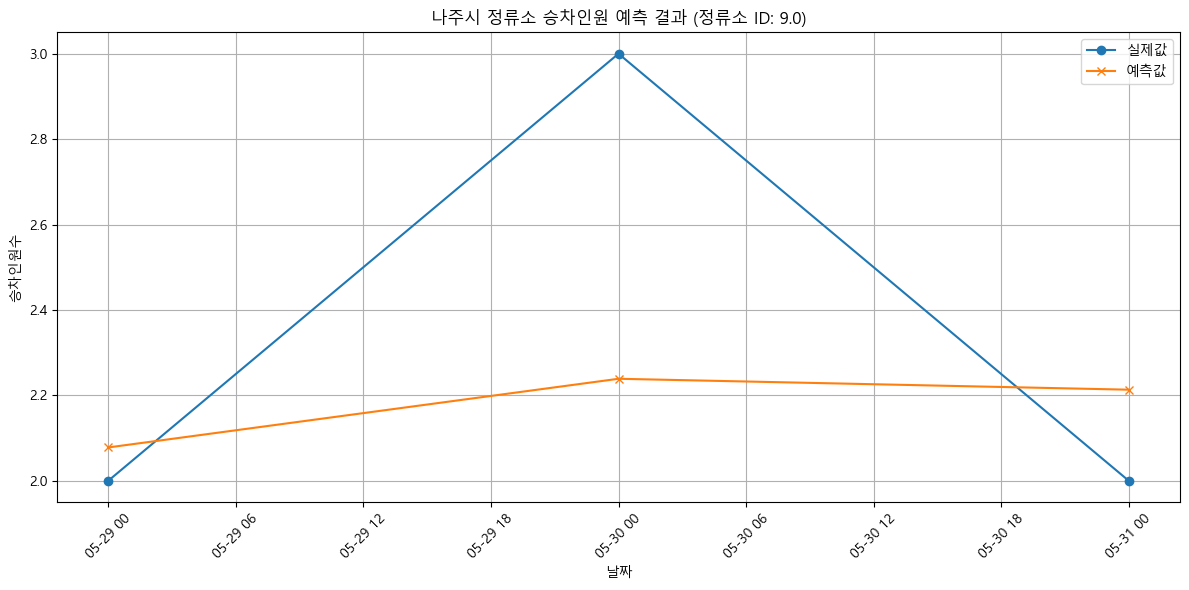

AttributeError: module 'streamlit' has no attribute 'tilte'

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import streamlit as st

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 기본 한글 폰트

# 파일 경로
file_path = "전라남도 나주시_시내버스 노선별 승하차 인원_20250601.csv"
df = pd.read_csv(file_path, encoding='euc-kr')

# 중복행 제거 및 결측값 제거
df = df.drop_duplicates()
df = df.dropna()

# 날짜와 요일 처리
df['날짜'] = pd.to_datetime(df['날짜'])
df['요일'] = df['날짜'].dt.dayofweek

# 정류소별 일별 승차인원 집계
daily_df = df.groupby(['정류소ID', '날짜', '요일'])['승차인원'].sum().reset_index()
daily_df = daily_df.sort_values(['정류소ID', '날짜'])

# 요일 원-핫 인코딩
weekday_dummies = pd.get_dummies(daily_df['요일'], prefix='요일')
daily_df = pd.concat([daily_df, weekday_dummies], axis=1)

# 시퀀스 생성
seq_length = 14
X_data = {}
y_data = {}
scalers = {}

for stop_id, group in daily_df.groupby('정류소ID'):
    group = group.sort_values('날짜')
    feature_cols = ['승차인원'] + list(weekday_dummies.columns)
    features = group[feature_cols].values

    # 승차인원 정규화
    scaler = MinMaxScaler()
    features[:, 0:1] = scaler.fit_transform(features[:, 0:1])
    scalers[stop_id] = scaler

    X_seq = []
    y_seq = []

    for i in range(len(features) - seq_length):
        X_seq.append(features[i:i+seq_length])
        y_seq.append(features[i+seq_length][0])  # 다음날 승차인원
        

    if X_seq:
        X_data[stop_id] = np.array(X_seq, dtype=np.float32)
        y_data[stop_id] = np.array(y_seq, dtype=np.float32)

# 정류소 하나 선택하여 데이터 분할
sample_stop_id = list(X_data.keys())[0]
X = X_data[sample_stop_id]
y = y_data[sample_stop_id]

# 학습 / 검증 분할 (80%/20%)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 모델 구성
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 모델 학습
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 예측
y_pred = model.predict(X_test)

# 정규화 복원
scaler = scalers[sample_stop_id]
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 테스트에 해당하는 날짜 추출
test_dates = daily_df[daily_df['정류소ID'] == sample_stop_id].iloc[-len(y_test):]['날짜'].values

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label="실제값", marker='o')
plt.plot(test_dates, y_pred_inv, label="예측값", marker='x')
plt.title(f"나주시 정류소 승차인원 예측 결과 (정류소 ID: {sample_stop_id})")
plt.xlabel("날짜")
plt.ylabel("승차인원수")
plt.xticks(rotation=45)         # 날짜 안 겹치게 회전
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#Streamlit UI
st.tilte("나주시 노선별 승차인원 예측")
